In [1]:
import os
import pandas as pd
import zipfile
import seaborn as sns
import numpy as np
import datetime
import math
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import matplotlib.patches as patches
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import DBSCAN
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, f1_score, accuracy_score
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer
from sklearn.naive_bayes import MultinomialNB
from sklearn.dummy import DummyClassifier

# 2020 Big Data Bowl Competition

In [2]:
#Question: How many yards will an NFL player gain after receiving a handoff?
#https://www.kaggle.com/competitions/nfl-big-data-bowl-2020/data

In [3]:
location="DataBowl2020.csv"
#Note I only have the Kaggle's training data, but will later split it up into smaller testing
#/training data sets
train = pd.read_csv(location)
train

/var/folders/cj/jcn0rhn52g397xd7gy7ndwnc0000gn/T/ipykernel_89726/3096263263.py:2: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv(location) #


,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,...,Week,Stadium,Location,StadiumType,Turf,GameWeather,Temperature,Humidity,WindSpeed,WindDirection
0,2017090700,20170907000118,away,73.91,34.84,1.69,1.13,0.40,81.99,177.18,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8.0,SW
1,2017090700,20170907000118,away,74.67,32.64,0.42,1.35,0.01,27.61,198.70,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8.0,SW
2,2017090700,20170907000118,away,74.00,33.20,1.22,0.59,0.31,3.01,202.73,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8.0,SW
3,2017090700,20170907000118,away,71.46,27.70,0.42,0.54,0.02,359.77,105.64,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8.0,SW
4,2017090700,20170907000118,away,69.32,35.42,1.82,2.43,0.16,12.63,164.31,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8.0,SW
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
682149,2019112500,20191125003789,home,69.58,31.33,4.19,1.33,0.43,92.32,20.94,...,12,Los Angeles Memorial Coliseum,"Los Angeles, CA",Outdoor,Grass,Clear,62.0,64.0,5,WSW
682150,2019112500,20191125003789,home,72.16,25.09,1.01,1.40,0.08,65.83,76.48,...,12,Los Angeles Memorial Coliseum,"Los Angeles, CA",Outdoor,Grass,Clear,62.0,64.0,5,WSW
682151,2019112500,20191125003789,home,72.23,31.95,1.75,0.68,0.17,93.99,90.26,...,12,Los Angeles Memorial Coliseum,"Los Angeles, CA",Outdoor,Grass,Clear,62.0,64.0,5,WSW
682152,2019112500,20191125003789,home,72.08,26.74,0.70,1.59,0.07,61.47,48.34,...,12,Los Angeles Memorial Coliseum,"Los Angeles, CA",Outdoor,Grass,Clear,62.0,64.0,5,WSW


In [5]:
train.shape

(682154, 49)

### Begin Exploring the Data

In [6]:
train.columns

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'Yards', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')

In [7]:
#look at the first row
train.iloc[0]

GameId                                  2017090700
PlayId                              20170907000118
Team                                          away
X                                            73.91
Y                                            34.84
S                                             1.69
A                                             1.13
Dis                                            0.4
Orientation                                  81.99
Dir                                         177.18
NflId                                       496723
DisplayName                             Eric Berry
JerseyNumber                                    29
Season                                        2017
YardLine                                        35
Quarter                                          1
GameClock                                 14:14:00
PossessionTeam                                  NE
Down                                             3
Distance                       

In [8]:
#Expect only 22 players for each play: 11 on each side
train[train["PlayId"] == 20170907000118] #arbitrary play picked

,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,...,Week,Stadium,Location,StadiumType,Turf,GameWeather,Temperature,Humidity,WindSpeed,WindDirection
0,2017090700,20170907000118,away,73.91,34.84,1.69,1.13,0.40,81.99,177.18,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8.0,SW
1,2017090700,20170907000118,away,74.67,32.64,0.42,1.35,0.01,27.61,198.70,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8.0,SW
2,2017090700,20170907000118,away,74.00,33.20,1.22,0.59,0.31,3.01,202.73,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8.0,SW
3,2017090700,20170907000118,away,71.46,27.70,0.42,0.54,0.02,359.77,105.64,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8.0,SW
4,2017090700,20170907000118,away,69.32,35.42,1.82,2.43,0.16,12.63,164.31,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8.0,SW
5,2017090700,20170907000118,away,75.06,24.00,1.01,0.32,0.18,308.34,95.01,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8.0,SW
6,2017090700,20170907000118,away,74.11,16.64,1.11,0.83,0.02,357.23,322.59,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8.0,SW
7,2017090700,20170907000118,away,73.37,18.73,1.24,0.74,0.13,328.52,270.04,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8.0,SW
8,2017090700,20170907000118,away,56.63,26.90,0.26,1.86,0.28,344.70,55.31,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8.0,SW
9,2017090700,20170907000118,away,73.35,38.83,4.55,0.76,0.51,75.47,190.84,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8.0,SW


## Clean-up Data

Looking for missing values and column types.

Use article for inspiration: https://www.kaggle.com/code/theholycityweb/data-science-fa19-nfl-intro

In [9]:
train.isna().sum()

GameId                         0
PlayId                         0
Team                           0
X                              0
Y                              0
S                              0
A                              0
Dis                            0
Orientation                   23
Dir                           28
NflId                          0
DisplayName                    0
JerseyNumber                   0
Season                         0
YardLine                       0
Quarter                        0
GameClock                      0
PossessionTeam                 0
Down                           0
Distance                       0
FieldPosition               8602
HomeScoreBeforePlay            0
VisitorScoreBeforePlay         0
NflIdRusher                    0
OffenseFormation              88
OffensePersonnel               0
DefendersInTheBox             22
DefensePersonnel               0
PlayDirection                  0
TimeHandoff                    0
TimeSnap  

In [10]:
train.dtypes

GameId                      int64
PlayId                      int64
Team                       object
X                         float64
Y                         float64
S                         float64
A                         float64
Dis                       float64
Orientation               float64
Dir                       float64
NflId                       int64
DisplayName                object
JerseyNumber                int64
Season                      int64
YardLine                    int64
Quarter                     int64
GameClock                  object
PossessionTeam             object
Down                        int64
Distance                    int64
FieldPosition              object
HomeScoreBeforePlay         int64
VisitorScoreBeforePlay      int64
NflIdRusher                 int64
OffenseFormation           object
OffensePersonnel           object
DefendersInTheBox         float64
DefensePersonnel           object
PlayDirection              object
TimeHandoff   

In [11]:
#remove certain columns
columns_to_remove = ['WindSpeed', 'WindDirection', 'GameWeather', 'StadiumType', 'GameClock']
train.drop(columns_to_remove, axis=1, inplace=True)

In [12]:
#Fill in missing values (works b/c time based)
train['Humidity'].fillna(method='ffill', inplace=True)
train['Temperature'].fillna(method='ffill', inplace=True)

/var/folders/cj/jcn0rhn52g397xd7gy7ndwnc0000gn/T/ipykernel_86076/2561486145.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train['Humidity'].fillna(method='ffill', inplace=True)
/var/folders/cj/jcn0rhn52g397xd7gy7ndwnc0000gn/T/ipykernel_86076/2561486145.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train['Temperature'].fillna(method='ffill', inplace=True)


In [13]:
#Fill-in Nulls by these rules
na_map = {
    # What is the average orientation of the playrees
    'Orientation': train['Orientation'].mean(),
    # Average direction 
    'Dir': train['Dir'].mean(),
    # Average # of defenders in the box (# of defenders directly opposing person with the ball)
    'DefendersInTheBox': np.math.ceil(train['DefendersInTheBox'].mean()),
    # What formation the team is using is really important, but often some teams use custom formations
    # In the case we will just say that we don't know
    'OffenseFormation': 'UNKNOWN'
}

train.fillna(na_map, inplace=True)

/var/folders/cj/jcn0rhn52g397xd7gy7ndwnc0000gn/T/ipykernel_86076/3069786791.py:8: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  'DefendersInTheBox': np.math.ceil(train['DefendersInTheBox'].mean()),


In [14]:
#Update field position for when at the 50 yard line
train['FieldPosition'] = np.where(train['YardLine'] == 50, train['PossessionTeam'], train['FieldPosition'])

### Handle time data

In [15]:
#Just get difference between handoff and snap time in seconds
train['TimeHandoff'] = train['TimeHandoff'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.%fZ"))
train['TimeSnap'] = train['TimeSnap'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.%fZ"))
train['TimeDelta'] = train.apply(lambda row: (row['TimeHandoff'] - row['TimeSnap']).total_seconds(), axis=1)
train.drop(['TimeSnap','TimeHandoff'],axis=1,inplace=True)

train['BirthYear']=train['PlayerBirthDate'].apply(lambda x : int(x.split('/')[2]))

train.drop(['PlayerBirthDate'],axis=1,inplace=True)

## Create New Columns (+ Relevant Features)

In [16]:
train["PlayerHeight"]

0         6-0
1         6-3
2         6-3
3         6-3
4         6-0
         ... 
682149    6-3
682150    6-1
682151    6-3
682152    6-1
682153    6-0
Name: PlayerHeight, Length: 682154, dtype: object

In [17]:
#Height to inches
def convert_height_to_inches(height):
    feet, inches = map(int, height.split('-'))
    total_inches = (feet * 12) + inches
    return total_inches

# Apply the function to the "PlayerHeight" column
train['PlayerHeightInches'] = train['PlayerHeight'].apply(convert_height_to_inches)

In [18]:
train["DefensePersonnel"].value_counts()

DefensePersonnel
4 DL, 2 LB, 5 DB          177188
4 DL, 3 LB, 4 DB          173250
3 DL, 4 LB, 4 DB          110418
2 DL, 4 LB, 5 DB           81378
3 DL, 3 LB, 5 DB           74932
2 DL, 3 LB, 6 DB           17336
4 DL, 1 LB, 6 DB           10450
5 DL, 2 LB, 4 DB            7084
4 DL, 4 LB, 3 DB            6490
3 DL, 2 LB, 6 DB            5258
5 DL, 3 LB, 3 DB            3212
1 DL, 4 LB, 6 DB            2200
3 DL, 5 LB, 3 DB            1672
5 DL, 4 LB, 2 DB            1672
6 DL, 3 LB, 2 DB            1408
6 DL, 4 LB, 1 DB            1364
5 DL, 1 LB, 5 DB            1100
1 DL, 5 LB, 5 DB             924
6 DL, 2 LB, 3 DB             880
2 DL, 5 LB, 4 DB             616
1 DL, 3 LB, 7 DB             506
2 DL, 2 LB, 7 DB             418
4 DL, 5 LB, 2 DB             352
5 DL, 5 LB, 1 DB             330
3 DL, 1 LB, 7 DB             286
2 DL, 4 LB, 4 DB, 1 RB       220
1 DL, 4 LB, 5 DB, 1 RB       154
5 DL, 3 LB, 2 DB, 1 OL       154
0 DL, 5 LB, 6 DB             132
0 DL, 4 LB, 7 DB          

In [19]:
#Count number of DL, LB, DB, and others
def process_defense(x):
    num=[]
    num=x.split(',')
    dl=int(num[0].split(' ')[0])
    lb=int(num[1].split(' ')[1])
    db=int(num[2].split(' ')[1])
    if(len(num)>3):
         ol=int(num[3].split(' ')[1])
    else:
         ol=0
    return [dl,lb,db,ol]

values=train['DefensePersonnel'].apply(process_defense)

u,v,x,y=list(map(list,zip(*values)))

train['DL']=u
train['LB']=v
train['DB']=x
train['OL']=y #extra players


In [20]:
train[["DefensePersonnel", "DL", "LB", "DB", "OL"]] #confirming this worked

,DefensePersonnel,DL,LB,DB,OL
0,"2 DL, 3 LB, 6 DB",2,3,6,0
1,"2 DL, 3 LB, 6 DB",2,3,6,0
2,"2 DL, 3 LB, 6 DB",2,3,6,0
3,"2 DL, 3 LB, 6 DB",2,3,6,0
4,"2 DL, 3 LB, 6 DB",2,3,6,0
...,...,...,...,...,...
682149,"3 DL, 3 LB, 5 DB",3,3,5,0
682150,"3 DL, 3 LB, 5 DB",3,3,5,0
682151,"3 DL, 3 LB, 5 DB",3,3,5,0
682152,"3 DL, 3 LB, 5 DB",3,3,5,0


# Classification Goal (Predict if run is going to be greater than $3$ yards or not)

In [21]:
#add classifier for if yards > 4 (binary choice)
train["Yards_Greater_Than_3"] = (train["Yards"] > 3).astype(int)

In [22]:
train[["Yards_Greater_Than_3", "Yards"]] #confirming this worked

,Yards_Greater_Than_3,Yards
0,1,8
1,1,8
2,1,8
3,1,8
4,1,8
...,...,...
682149,1,4
682150,1,4
682151,1,4
682152,1,4


## Turn X, Y position of each player into something useful

Use clustering

In [23]:
#PREDICTED PLAYER POSITION IN 0.5s
t = 0.5

#x = x_0 + vt + 1/2 a t^2
angles = train["Dir"].apply(math.radians)
cos = angles.apply(math.cos)
sin = angles.apply(math.sin)
train["xPred"] = train["X"] + train["S"] * cos * t + 0.5 * train["A"] * cos * t * t
train["yPred"] = train["Y"] + train["S"] * sin * t + 0.5 * train["A"] * sin * t * t

In [24]:
#Clustering based on player positions
train_abridged = train[["X", "Y", "PlayId", "NflId", "NflIdRusher", "Team", "Position"]]

dbscan = DBSCAN(eps=10, min_samples=2)

# Create an empty list to store the results
result_data = []

# Create an empty column to store the cluster labels
train_abridged.loc[:, 'ClusterLabel'] = -1

# Iterate over each unique 'PlayId'
for play_id in train_abridged['PlayId'].unique():
    play_data = train_abridged[train_abridged['PlayId'] == play_id]

    # Fit the model on the players' coordinates
    dbscan.fit(play_data[['X', 'Y']])
    
    # Assign cluster labels to the players
    play_data.loc[:, 'ClusterLabel'] = dbscan.labels_ #was done slightly different before, gave lots of errors

    # Identify the running back and determine which team they belong to
    running_back = play_data[play_data['NflId'] == play_data['NflIdRusher']]
    rb_team = running_back.iloc[0]['Team']
    rb_cluster_label = running_back.iloc[0]['ClusterLabel']
    
    # Count the number of additional offensive players (excluding 'QB') and defensive players in the same cluster as the running back
    offensive_players = play_data[(play_data['Team'] == rb_team) & (play_data['ClusterLabel'] == rb_cluster_label) & (play_data['NflId'] != play_data['NflIdRusher']) & (play_data['Position'] != 'QB')]
    defensive_players = play_data[(play_data['Team'] != rb_team) & (play_data['ClusterLabel'] == rb_cluster_label)]
    
    # Calculate the difference between offensive and defensive players
    cluster_diff = len(offensive_players) - len(defensive_players)
    
    # Append the result to the list
    result_data.append({'PlayId': play_id, 'ClusterDiff': cluster_diff})

result_df = pd.DataFrame(result_data)

/var/folders/cj/jcn0rhn52g397xd7gy7ndwnc0000gn/T/ipykernel_86076/1986551470.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_abridged.loc[:, 'ClusterLabel'] = -1


In [25]:
result_df

,PlayId,ClusterDiff
0,20170907000118,-1
1,20170907000139,-1
2,20170907000189,-1
3,20170907000345,-2
4,20170907000395,0
...,...,...
31002,20191125003419,-2
31003,20191125003440,-2
31004,20191125003496,-2
31005,20191125003768,-2


In [26]:
result_df['ClusterDiff'].value_counts()

ClusterDiff
-1    18609
-2    10488
 0     1766
-3       72
 1       44
 5       11
 4        6
 2        5
 3        3
 6        3
Name: count, dtype: int64

In [27]:
#Explore results
# Group train DataFrame by 'PlayId' and calculate the mean of 'Yards'
#will be the same yards amount for all of them
yards_mean = train.groupby('PlayId')['Yards'].mean().reset_index()

# Merge yards_mean with result_df on 'PlayId'
merged_df = pd.merge(result_df, yards_mean, on='PlayId')

# Print the merged DataFrame
merged_df

,PlayId,ClusterDiff,Yards
0,20170907000118,-1,8.0
1,20170907000139,-1,3.0
2,20170907000189,-1,5.0
3,20170907000345,-2,2.0
4,20170907000395,0,7.0
...,...,...,...
31002,20191125003419,-2,1.0
31003,20191125003440,-2,1.0
31004,20191125003496,-2,1.0
31005,20191125003768,-2,1.0


/Users/charliemorris/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/charliemorris/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/charliemorris/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


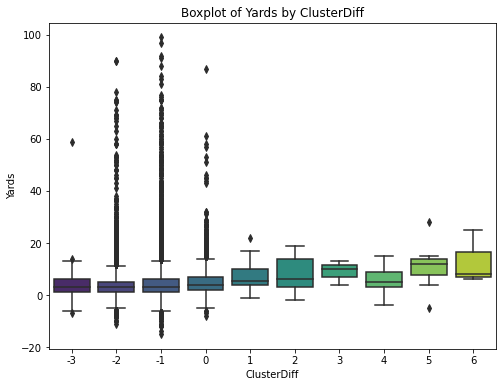

In [28]:
# Count the occurrences of each ClusterDiff value
counts = merged_df['ClusterDiff'].value_counts().reset_index()
counts.columns = ['ClusterDiff', 'Count']

# Create a custom color palette based on the number of values
n_colors = len(counts)
colors = sns.color_palette("viridis", n_colors)

# Create a boxplot with colored boxes
plt.figure(figsize=(8, 6))
sns.boxplot(data=merged_df, x='ClusterDiff', y='Yards', palette=colors)
plt.title('Boxplot of Yards by ClusterDiff')
plt.xlabel('ClusterDiff')
plt.ylabel('Yards')

# Show the plot
plt.show()

In [29]:
# Group by 'ClusterDiff' and calculate mean, median, standard deviation, and count
grouped_data = merged_df.groupby('ClusterDiff')['Yards'].agg(['mean', 'median', 'std', 'count']).reset_index()
grouped_data.columns = ['ClusterDiff', 'Mean', 'Median', 'StandardDeviation', 'Count']

# Print the resulting DataFrame
grouped_data.sort_values(by='Median')

,ClusterDiff,Mean,Median,StandardDeviation,Count
0,-3,4.541667,3.0,7.589722,72
1,-2,3.487128,3.0,5.604272,10488
2,-1,4.532323,3.0,6.820292,18609
3,0,5.265006,4.0,6.644855,1766
7,4,5.666667,5.0,6.470446,6
4,1,6.477273,5.5,4.872746,44
5,2,8.000000,6.0,8.455767,5
9,6,13.000000,8.0,10.440307,3
6,3,9.000000,10.0,4.582576,3
8,5,11.000000,12.0,8.173127,11


### Repeat clustering process (but now on the predicted points after 0.5s)

In [30]:
#Clustering
train_abridged = train[["xPred", "yPred", "PlayId", "NflId", "NflIdRusher", "Team", "Position"]]

dbscan = DBSCAN(eps=10, min_samples=2)  # Adjust the parameters as needed

# Create an empty list to store the results
result_data2 = []

# Create an empty column to store the cluster labels
train_abridged.loc[:, 'ClusterLabel'] = -1

# Iterate over each unique 'PlayId'
for play_id in train_abridged['PlayId'].unique():
    play_data = train_abridged[train_abridged['PlayId'] == play_id]

    # Fit the model on the players' coordinates
    dbscan.fit(play_data[['xPred', 'yPred']])
    
    # Assign cluster labels to the players
    play_data.loc[:, 'ClusterLabel'] = dbscan.labels_ #was done slightly different before, gave lots of errors
    
    # Identify the running back and determine which team they belong to
    running_back = play_data[play_data['NflId'] == play_data['NflIdRusher']]
    rb_team = running_back.iloc[0]['Team']
    rb_cluster_label = running_back.iloc[0]['ClusterLabel']
    
    # Count the number of additional offensive players (excluding 'QB') and defensive players in the same cluster as the running back
    offensive_players = play_data[(play_data['Team'] == rb_team) & (play_data['ClusterLabel'] == rb_cluster_label) & (play_data['NflId'] != play_data['NflIdRusher']) & (play_data['Position'] != 'QB')]
    defensive_players = play_data[(play_data['Team'] != rb_team) & (play_data['ClusterLabel'] == rb_cluster_label)]
    
    # Calculate the difference between offensive and defensive players
    cluster_diff = len(offensive_players) - len(defensive_players)
    
    # Append the result to the list
    result_data2.append({'PlayId': play_id, 'ClusterDiff': cluster_diff})

result_df2 = pd.DataFrame(result_data2)

/var/folders/cj/jcn0rhn52g397xd7gy7ndwnc0000gn/T/ipykernel_86076/419774542.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_abridged.loc[:, 'ClusterLabel'] = -1


In [31]:
# Merge yards_mean with result_df2 on 'PlayId'
merged_df2 = pd.merge(result_df2, yards_mean, on='PlayId')

# Print the merged DataFrame
merged_df2

,PlayId,ClusterDiff,Yards
0,20170907000118,-1,8.0
1,20170907000139,-1,3.0
2,20170907000189,-1,5.0
3,20170907000345,-2,2.0
4,20170907000395,0,7.0
...,...,...,...
31002,20191125003419,-2,1.0
31003,20191125003440,-2,1.0
31004,20191125003496,-2,1.0
31005,20191125003768,-2,1.0


/Users/charliemorris/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/charliemorris/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/charliemorris/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


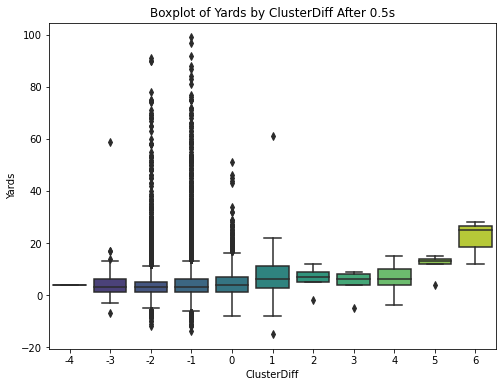

In [32]:
# Count the occurrences of each ClusterDiff value
counts = merged_df2['ClusterDiff'].value_counts().reset_index()
counts.columns = ['ClusterDiff', 'Count']

# Create a custom color palette based on the number of values
n_colors = len(counts)
colors = sns.color_palette("viridis", n_colors)

# Create a boxplot with colored boxes
plt.figure(figsize=(8, 6))
sns.boxplot(data=merged_df2, x='ClusterDiff', y='Yards', palette=colors)
plt.title('Boxplot of Yards by ClusterDiff After 0.5s')
plt.xlabel('ClusterDiff')
plt.ylabel('Yards')

# Show the plot
plt.show()

In [33]:
# Group by 'ClusterDiff' and calculate mean, median, standard deviation, and count
grouped_data = merged_df2.groupby('ClusterDiff')['Yards'].agg(['mean', 'median', 'std', 'count']).reset_index()
grouped_data.columns = ['ClusterDiff', 'Mean', 'Median', 'StandardDeviation', 'Count']

# Print the resulting DataFrame
grouped_data.sort_values(by='Median')

,ClusterDiff,Mean,Median,StandardDeviation,Count
1,-3,4.365591,3.0,6.993452,93
2,-2,3.644828,3.0,5.835208,11417
3,-1,4.516069,3.0,6.818530,17767
0,-4,4.000000,4.0,NaN,1
4,0,4.977630,4.0,5.874477,1654
5,1,7.348837,6.0,10.761226,43
7,3,4.400000,6.0,5.594640,5
8,4,6.555556,6.0,5.746980,9
6,2,6.666667,7.0,4.000000,9
9,5,11.833333,13.0,4.020779,6


#### The above information is not necessarily giving me anything new when looking at 0.5 seconds later, so I will not reuse this feature in my model

## Choose Features for Final Model

In [34]:
training = train[train['NflId'] == train['NflIdRusher']] #one row per play
relevantFeatures = training[['S','PlayId', 'Yards_Greater_Than_3', 'A', 'Down', 'Distance', 'OffenseFormation', "DL", "LB", 'DefendersInTheBox']]
relevantFeatures

,S,PlayId,Yards_Greater_Than_3,A,Down,Distance,OffenseFormation,DL,LB,DefendersInTheBox
18,3.63,20170907000118,1,3.35,3,2,SHOTGUN,2,3,6.0
40,3.06,20170907000139,0,2.41,1,10,SHOTGUN,2,3,6.0
62,5.77,20170907000189,1,2.42,1,10,SINGLEBACK,2,3,7.0
84,4.45,20170907000345,0,3.20,2,2,JUMBO,4,4,9.0
98,3.90,20170907000395,1,2.53,1,10,SHOTGUN,3,2,7.0
...,...,...,...,...,...,...,...,...,...,...
682052,4.26,20191125003419,0,2.54,1,10,PISTOL,4,3,8.0
682074,4.49,20191125003440,0,3.14,2,9,PISTOL,3,3,7.0
682096,4.42,20191125003496,0,1.54,1,10,SINGLEBACK,3,3,8.0
682118,4.80,20191125003768,0,3.26,1,10,PISTOL,4,3,7.0


In [35]:
# Define the conditions and corresponding labels for "Distance" (make it a category variable)
conditions = [
    training['Distance'] < 3,
    (training['Distance'] >= 3) & (training['Distance'] < 7),
    (training['Distance'] >= 7) & (training['Distance'] < 12)
]

labels = ['short', 'medium', 'long']

# Use np.select to create the new column
relevantFeatures['DistanceCategory'] = np.select(conditions, labels, default='veryLong')

/var/folders/cj/jcn0rhn52g397xd7gy7ndwnc0000gn/T/ipykernel_86076/945971867.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevantFeatures['DistanceCategory'] = np.select(conditions, labels, default='veryLong')


In [36]:
one_hot_encoded = pd.get_dummies(relevantFeatures['OffenseFormation'], prefix='Formation') #now for formation
one_hot_encoded = one_hot_encoded.astype(int)

one_hot_encoded2 = pd.get_dummies(relevantFeatures['DistanceCategory'], prefix='Distance') #now for distance category
one_hot_encoded2 = one_hot_encoded2.astype(int)

relevantFeatures = pd.concat([relevantFeatures, one_hot_encoded, one_hot_encoded2], axis=1)

relevantFeatures

,S,PlayId,Yards_Greater_Than_3,A,Down,Distance,OffenseFormation,DL,LB,DefendersInTheBox,...,Formation_JUMBO,Formation_PISTOL,Formation_SHOTGUN,Formation_SINGLEBACK,Formation_UNKNOWN,Formation_WILDCAT,Distance_long,Distance_medium,Distance_short,Distance_veryLong
18,3.63,20170907000118,1,3.35,3,2,SHOTGUN,2,3,6.0,...,0,0,1,0,0,0,0,0,1,0
40,3.06,20170907000139,0,2.41,1,10,SHOTGUN,2,3,6.0,...,0,0,1,0,0,0,1,0,0,0
62,5.77,20170907000189,1,2.42,1,10,SINGLEBACK,2,3,7.0,...,0,0,0,1,0,0,1,0,0,0
84,4.45,20170907000345,0,3.20,2,2,JUMBO,4,4,9.0,...,1,0,0,0,0,0,0,0,1,0
98,3.90,20170907000395,1,2.53,1,10,SHOTGUN,3,2,7.0,...,0,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
682052,4.26,20191125003419,0,2.54,1,10,PISTOL,4,3,8.0,...,0,1,0,0,0,0,1,0,0,0
682074,4.49,20191125003440,0,3.14,2,9,PISTOL,3,3,7.0,...,0,1,0,0,0,0,1,0,0,0
682096,4.42,20191125003496,0,1.54,1,10,SINGLEBACK,3,3,8.0,...,0,0,0,1,0,0,1,0,0,0
682118,4.80,20191125003768,0,3.26,1,10,PISTOL,4,3,7.0,...,0,1,0,0,0,0,1,0,0,0


In [37]:
relevantFeatures.columns

Index(['S', 'PlayId', 'Yards_Greater_Than_3', 'A', 'Down', 'Distance',
       'OffenseFormation', 'DL', 'LB', 'DefendersInTheBox', 'DistanceCategory',
       'Formation_ACE', 'Formation_EMPTY', 'Formation_I_FORM',
       'Formation_JUMBO', 'Formation_PISTOL', 'Formation_SHOTGUN',
       'Formation_SINGLEBACK', 'Formation_UNKNOWN', 'Formation_WILDCAT',
       'Distance_long', 'Distance_medium', 'Distance_short',
       'Distance_veryLong'],
      dtype='object')

In [38]:
#Get rid of irrelevant columns
y = relevantFeatures['Yards_Greater_Than_3']
X_features = relevantFeatures.drop(['OffenseFormation', 'Yards_Greater_Than_3', 'Distance', 'DistanceCategory'], axis=1)
X = pd.merge(X_features, merged_df, on='PlayId') #merging with the clustering information at time of handoff
X

,S,PlayId,A,Down,DL,LB,DefendersInTheBox,Formation_ACE,Formation_EMPTY,Formation_I_FORM,...,Formation_SHOTGUN,Formation_SINGLEBACK,Formation_UNKNOWN,Formation_WILDCAT,Distance_long,Distance_medium,Distance_short,Distance_veryLong,ClusterDiff,Yards
0,3.63,20170907000118,3.35,3,2,3,6.0,0,0,0,...,1,0,0,0,0,0,1,0,-1,8.0
1,3.06,20170907000139,2.41,1,2,3,6.0,0,0,0,...,1,0,0,0,1,0,0,0,-1,3.0
2,5.77,20170907000189,2.42,1,2,3,7.0,0,0,0,...,0,1,0,0,1,0,0,0,-1,5.0
3,4.45,20170907000345,3.20,2,4,4,9.0,0,0,0,...,0,0,0,0,0,0,1,0,-2,2.0
4,3.90,20170907000395,2.53,1,3,2,7.0,0,0,0,...,1,0,0,0,1,0,0,0,0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31002,4.26,20191125003419,2.54,1,4,3,8.0,0,0,0,...,0,0,0,0,1,0,0,0,-2,1.0
31003,4.49,20191125003440,3.14,2,3,3,7.0,0,0,0,...,0,0,0,0,1,0,0,0,-2,1.0
31004,4.42,20191125003496,1.54,1,3,3,8.0,0,0,0,...,0,1,0,0,1,0,0,0,-2,1.0
31005,4.80,20191125003768,3.26,1,4,3,7.0,0,0,0,...,0,0,0,0,1,0,0,0,-2,1.0


In [39]:
X.drop(['PlayId', 'Yards'], axis=1, inplace=True)
X

,S,A,Down,DL,LB,DefendersInTheBox,Formation_ACE,Formation_EMPTY,Formation_I_FORM,Formation_JUMBO,Formation_PISTOL,Formation_SHOTGUN,Formation_SINGLEBACK,Formation_UNKNOWN,Formation_WILDCAT,Distance_long,Distance_medium,Distance_short,Distance_veryLong,ClusterDiff
0,3.63,3.35,3,2,3,6.0,0,0,0,0,0,1,0,0,0,0,0,1,0,-1
1,3.06,2.41,1,2,3,6.0,0,0,0,0,0,1,0,0,0,1,0,0,0,-1
2,5.77,2.42,1,2,3,7.0,0,0,0,0,0,0,1,0,0,1,0,0,0,-1
3,4.45,3.20,2,4,4,9.0,0,0,0,1,0,0,0,0,0,0,0,1,0,-2
4,3.90,2.53,1,3,2,7.0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31002,4.26,2.54,1,4,3,8.0,0,0,0,0,1,0,0,0,0,1,0,0,0,-2
31003,4.49,3.14,2,3,3,7.0,0,0,0,0,1,0,0,0,0,1,0,0,0,-2
31004,4.42,1.54,1,3,3,8.0,0,0,0,0,0,0,1,0,0,1,0,0,0,-2
31005,4.80,3.26,1,4,3,7.0,0,0,0,0,1,0,0,0,0,1,0,0,0,-2


In [40]:
def findParameters(param_grid, model):
    # perform cross-validation while searching for the best hyperparameter
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    grid_search = GridSearchCV(model, param_grid, cv=kfold, scoring='f1_macro', n_jobs=1)
    grid_search.fit(X, y)
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    print("Best parameters: " + str(best_params))
    print("Best f1_macro score average (from cross validation): " + str(best_score))  #mean of my 5 cross validation scores
    return best_params

In [41]:
def results(model):
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25)

    #Fit the model to the training data
    model.fit(X_train, y_train)

    # Make predictions on the training and testing data
    y_test_pred = model.predict(X_test)

    # Calculate the confusion matrix
    confusion = confusion_matrix(y_test, y_test_pred)

    # Calculate the ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])

    # Calculate the AUC (Area Under the ROC Curve)
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])

    # Calculate the macro F1 score
    macro_f1 = f1_score(y_test, y_test_pred, average='macro')

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_test_pred)

    # Print the results
    print("Confusion Matrix:")
    print(confusion)
    print("\nAUC (Area Under the ROC Curve):", roc_auc)
    print("\nMacro F1 Score:", macro_f1)
    print("\nAccuracy:", accuracy)

    # Plot the ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.3f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

### Logistic Regression

In [42]:
logreg = LogisticRegression(solver='sag') #annoying warnings will show
param_grid = {'C': [3.5, 3.6, 3.7, 3.8, 3.9, 4]} #regularization strength parameter C
best_parameters = findParameters(param_grid, logreg)
best_logreg = LogisticRegression(solver='sag', C=best_parameters['C'])  # Use the best value of C

/Users/charliemorris/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/charliemorris/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/charliemorris/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/charliemorris/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/charliemorris/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/cha

Best parameters: {'C': 3.5}
Best f1_macro score average (from cross validation): 0.5766555032054226


/Users/charliemorris/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Confusion Matrix:
[[3303 1019]
 [2054 1376]]

AUC (Area Under the ROC Curve): 0.6444721763895616

Macro F1 Score: 0.5774774377695706

Accuracy: 0.6035861713106295


/Users/charliemorris/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


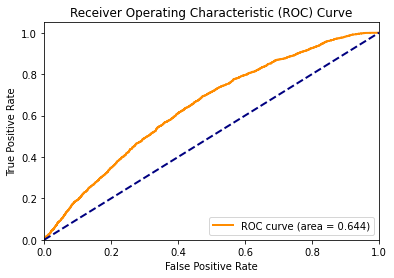

In [43]:
results(best_logreg)

Confusion Matrix:
[[2535 1953]
 [1804 1460]]

AUC (Area Under the ROC Curve): 0.49628175133689845

Macro F1 Score: 0.5058481150975929

Accuracy: 0.5153508771929824


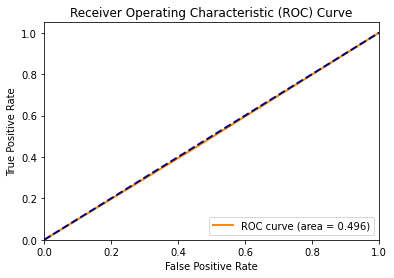

In [44]:
dummy=DummyClassifier(strategy='stratified')
results(dummy)

## Best Runners (Above Expectation)

In [45]:
runningBackData = training.groupby("NflId")['Yards'].agg(['mean', 'median', 'std', 'count'])

In [46]:
best_logreg.fit(X, y)
y_pred = best_logreg.predict(X)
training["PredBetter3"] = y_pred

/Users/charliemorris/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/var/folders/cj/jcn0rhn52g397xd7gy7ndwnc0000gn/T/ipykernel_86076/478955304.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training["PredBetter3"] = y_pred


In [47]:
#Find running backs with the most total number of carries above expectation
#Gives the count of these + value carries
result = training[training['Yards_Greater_Than_3'] > training['PredBetter3']].groupby(['DisplayName','PlayerWeight', 'PlayerHeight']).size()
result.sort_values(ascending=False)[:20]

DisplayName          PlayerWeight  PlayerHeight
Ezekiel Elliott      228           6-0             229
Todd Gurley          224           6-1             185
Derrick Henry        247           6-3             172
Leonard Fournette    228           6-0             168
Mark Ingram          215           5-9             165
Carlos Hyde          229           6-0             163
Le'Veon Bell         225           6-1             152
Jordan Howard        224           6-0             151
Christian McCaffrey  205           5-11            151
Frank Gore           212           5-9             150
Adrian Peterson      220           6-1             145
Marlon Mack          210           6-0             142
Peyton Barber        225           5-11            139
LeSean McCoy         210           5-11            139
Melvin Gordon        215           6-1             133
Chris Carson         222           5-11            129
Latavius Murray      230           6-3             123
Joe Mixon        

# Visualize Football Field

Inspiration code to make the field visual:
https://www.kaggle.com/code/robikscube/nfl-big-data-bowl-plotting-player-position/notebook

In [48]:
def create_football_field(linenumbers=True,
                          endzones=True,
                          highlight_line=False,
                          highlight_line_number=50,
                          highlighted_name='Line of Scrimmage',
                          fifty_is_los=False,
                          figsize=(12, 6.33)):
    """
    Function that plots the football field for viewing plays.
    Allows for showing or hiding endzones.
    """
    rect = patches.Rectangle((0, 0), 120, 53.3, linewidth=0.1,
                             edgecolor='r', facecolor='darkgreen', zorder=0)

    fig, ax = plt.subplots(1, figsize=figsize)
    ax.add_patch(rect)

    plt.plot([10, 10, 10, 20, 20, 30, 30, 40, 40, 50, 50, 60, 60, 70, 70, 80,
              80, 90, 90, 100, 100, 110, 110, 120, 0, 0, 120, 120],
             [0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3,
              53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 53.3, 0, 0, 53.3],
             color='white')
    if fifty_is_los:
        plt.plot([60, 60], [0, 53.3], color='gold')
        plt.text(62, 50, '<- Player Yardline at Snap', color='gold')
    # Endzones
    if endzones:
        ez1 = patches.Rectangle((0, 0), 10, 53.3,
                                linewidth=0.1,
                                edgecolor='r',
                                facecolor='blue',
                                alpha=0.2,
                                zorder=0)
        ez2 = patches.Rectangle((110, 0), 120, 53.3,
                                linewidth=0.1,
                                edgecolor='r',
                                facecolor='blue',
                                alpha=0.2,
                                zorder=0)
        ax.add_patch(ez1)
        ax.add_patch(ez2)
    plt.xlim(0, 120)
    plt.ylim(-5, 58.3)
    plt.axis('off')
    if linenumbers:
        for x in range(20, 110, 10):
            numb = x
            if x > 50:
                numb = 120 - x
            plt.text(x, 5, str(numb - 10),
                     horizontalalignment='center',
                     fontsize=20,  # fontname='Arial',
                     color='white')
            plt.text(x - 0.95, 53.3 - 5, str(numb - 10),
                     horizontalalignment='center',
                     fontsize=20,  # fontname='Arial',
                     color='white', rotation=180)
    if endzones:
        hash_range = range(11, 110)
    else:
        hash_range = range(1, 120)

    for x in hash_range:
        ax.plot([x, x], [0.4, 0.7], color='white')
        ax.plot([x, x], [53.0, 52.5], color='white')
        ax.plot([x, x], [22.91, 23.57], color='white')
        ax.plot([x, x], [29.73, 30.39], color='white')

    if highlight_line:
        hl = highlight_line_number
        plt.plot([hl, hl], [0, 53.3], color='yellow')
        plt.text(hl + 2, 50, '<- {}'.format(highlighted_name),
                 color='yellow')
    return fig, ax

In [49]:
def createPlay(playid):
    yl = train.query("PlayId == @playid")['YardLine'].tolist()[0]
    fig, ax = create_football_field()
    train.query("PlayId == @playid and Team == 'away'") \
        .plot(x='X', y='Y', kind='scatter', ax=ax, color='orange', s=30, legend='Away')
    train.query("PlayId == @playid and Team == 'home'") \
        .plot(x='X', y='Y', kind='scatter', ax=ax, color='blue', s=30, legend='Home')
    plt.title(f'Play # {playid}')
    plt.legend()
    plt.show()

In [50]:
unique_play_ids = train['PlayId'].unique()
print(unique_play_ids[:20]) #Choose one of these plays to show

[20170907000118 20170907000139 20170907000189 20170907000345
 20170907000395 20170907000473 20170907000516 20170907000653
 20170907000680 20170907000801 20170907000917 20170907001004
 20170907001077 20170907001156 20170907001177 20170907001296
 20170907001355 20170907001376 20170907001443 20170907001488]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


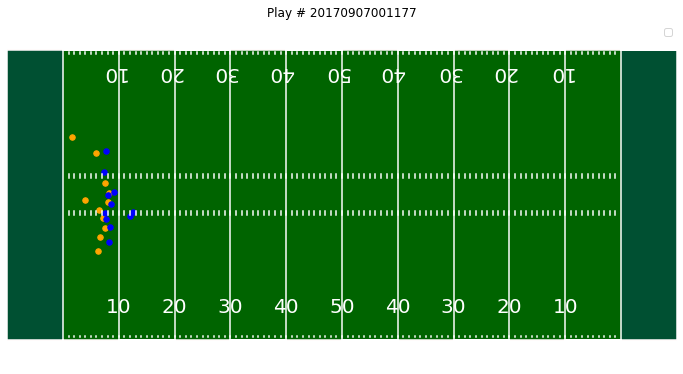

In [51]:
playid = 20170907001177
createPlay(playid)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


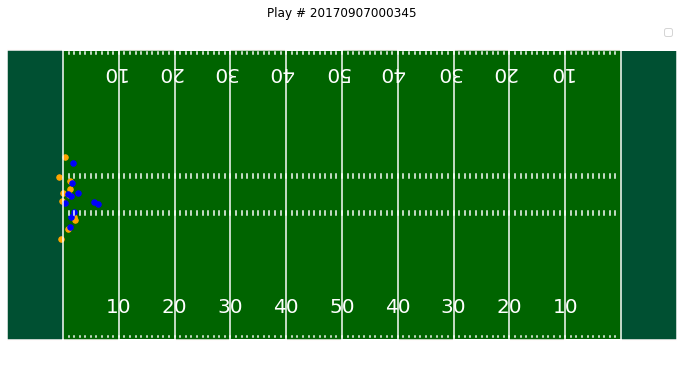

In [52]:
playid = 20170907000345
createPlay(playid)

### Other cool visualizations from the data 

In [53]:
training

,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,...,BirthYear,PlayerHeightInches,DL,LB,DB,OL,Yards_Greater_Than_3,xPred,yPred,PredBetter3
18,2017090700,20170907000118,home,78.75,30.53,3.63,3.35,0.38,161.98,245.74,...,1992,70,2,3,6,0,1,77.832201,28.493512,0
40,2017090700,20170907000139,home,71.07,27.16,3.06,2.41,0.34,210.70,312.20,...,1992,70,2,3,6,0,0,72.300088,25.803402,0
62,2017090700,20170907000189,home,48.66,19.11,5.77,2.42,0.60,140.82,221.96,...,1992,70,2,3,6,0,1,46.289737,16.978800,1
84,2017090700,20170907000345,home,15.53,25.36,4.45,3.20,0.46,186.22,275.44,...,1990,71,4,4,3,0,0,15.778859,22.746823,0
98,2017090700,20170907000395,away,29.99,27.12,3.90,2.53,0.44,34.27,157.92,...,1995,71,3,2,6,0,1,27.889957,27.971885,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
682052,2019112500,20191125003419,away,68.95,28.28,4.26,2.54,0.42,243.61,255.90,...,1997,70,4,3,4,0,0,68.353752,25.906238,0
682074,2019112500,20191125003440,away,69.11,26.19,4.49,3.14,0.43,249.98,263.67,...,1997,70,3,3,5,0,0,68.819203,23.568580,0
682096,2019112500,20191125003496,away,27.44,24.46,4.42,1.54,0.43,263.76,284.49,...,1995,73,3,3,5,0,0,28.041132,22.133920,0
682118,2019112500,20191125003768,away,78.46,28.40,4.80,3.26,0.47,274.83,262.25,...,1997,70,4,3,4,0,0,78.081406,25.618144,0


In [54]:
training.columns

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'PossessionTeam', 'Down', 'Distance', 'FieldPosition',
       'HomeScoreBeforePlay', 'VisitorScoreBeforePlay', 'NflIdRusher',
       'OffenseFormation', 'OffensePersonnel', 'DefendersInTheBox',
       'DefensePersonnel', 'PlayDirection', 'Yards', 'PlayerHeight',
       'PlayerWeight', 'PlayerCollegeName', 'Position', 'HomeTeamAbbr',
       'VisitorTeamAbbr', 'Week', 'Stadium', 'Location', 'Turf', 'Temperature',
       'Humidity', 'TimeDelta', 'BirthYear', 'PlayerHeightInches', 'DL', 'LB',
       'DB', 'OL', 'Yards_Greater_Than_3', 'xPred', 'yPred', 'PredBetter3'],
      dtype='object')

In [55]:
training["OffenseFormation"].value_counts()

OffenseFormation
SINGLEBACK    13624
SHOTGUN        9389
I_FORM         6225
PISTOL          979
JUMBO           677
WILDCAT          77
EMPTY            31
UNKNOWN           4
ACE               1
Name: count, dtype: int64

/Users/charliemorris/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/charliemorris/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/charliemorris/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0, 0.5, 'Average Yards Gained Per Carry')

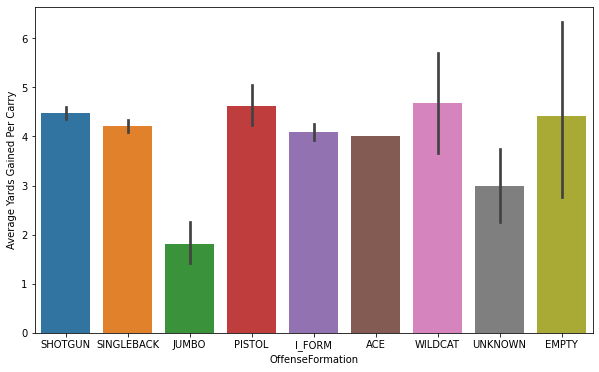

In [75]:
plt.figure(figsize=(10, 6))
sns.barplot(x='OffenseFormation', y='Yards', data=training)
plt.ylabel('Average Yards Gained Per Carry')

/Users/charliemorris/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/charliemorris/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/charliemorris/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0, 0.5, 'Probability of Yardage Greater than 3')

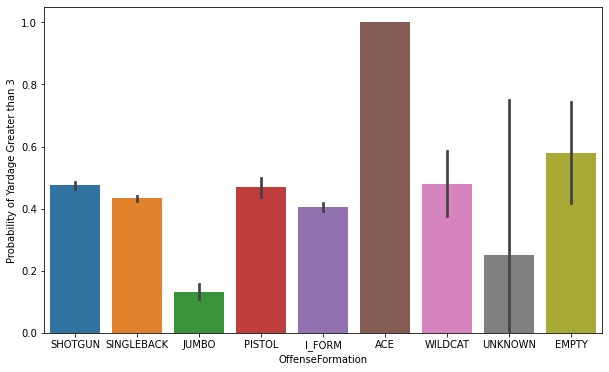

In [76]:
plt.figure(figsize=(10, 6))
sns.barplot(x='OffenseFormation', y='Yards_Greater_Than_3', data=training)
plt.ylabel('Probability of Yardage Greater than 3')

/Users/charliemorris/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/charliemorris/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/charliemorris/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0.5, 1.0, 'Distribution of Yards Gained')

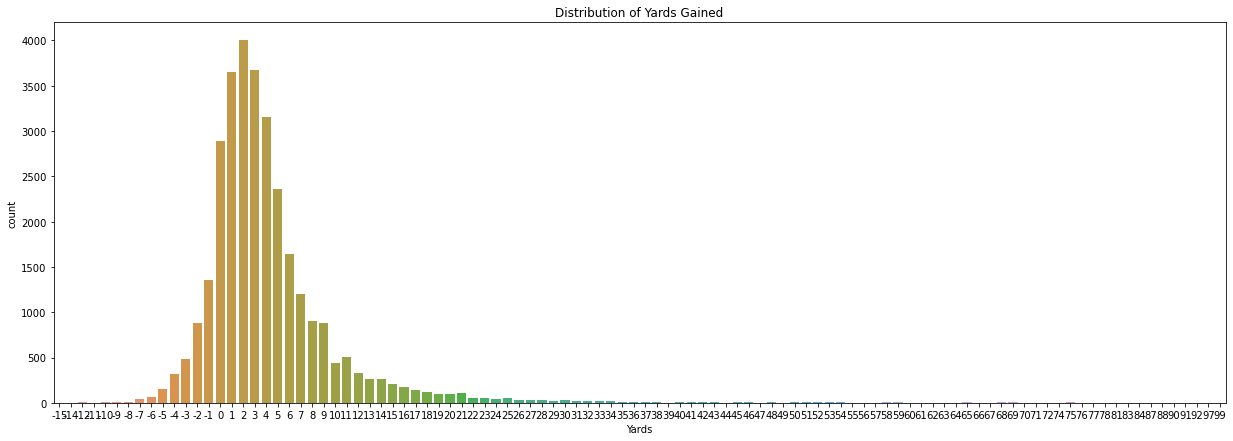

In [77]:
plt.figure(figsize=(21, 7))
sns.countplot(x='Yards', data=training)
plt.title('Distribution of Yards Gained')

/Users/charliemorris/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/charliemorris/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/charliemorris/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0, 0.5, 'Average Yards Per Carry')

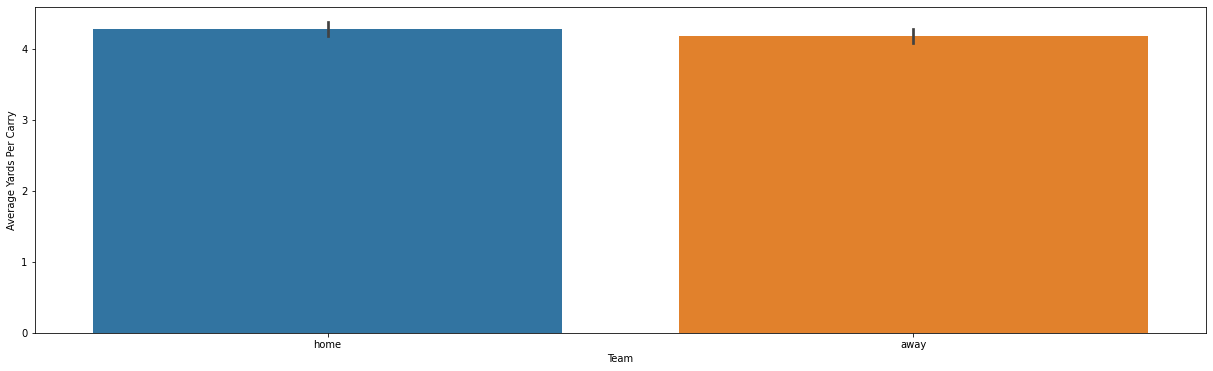

In [78]:
plt.figure(figsize=(21, 6))
sns.barplot(x='Team', y='Yards', data=training)
plt.ylabel('Average Yards Per Carry')

In [79]:
training["Down"].value_counts()

Down
1    17925
2    10393
3     2421
4      268
Name: count, dtype: int64

/Users/charliemorris/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/charliemorris/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/charliemorris/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0, 0.5, 'Average Yards Per Carry')

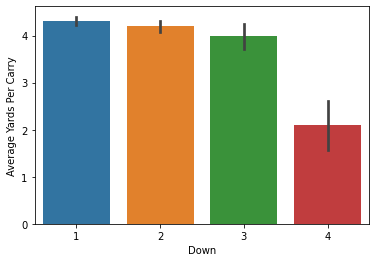

In [80]:
sns.barplot(x='Down', y='Yards', data=training)
plt.ylabel('Average Yards Per Carry')

/Users/charliemorris/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/charliemorris/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/charliemorris/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0, 0.5, 'Average Yards Per Carry')

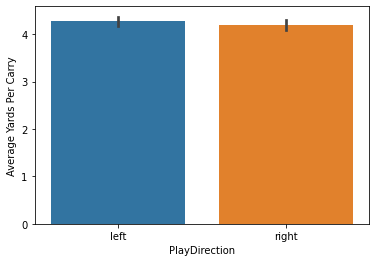

In [81]:
sns.barplot(x='PlayDirection', y='Yards', data=training)
plt.ylabel('Average Yards Per Carry')

/Users/charliemorris/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/charliemorris/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0.5, 1.0, 'Acceleration Per Carry vs. Yardage Gained')

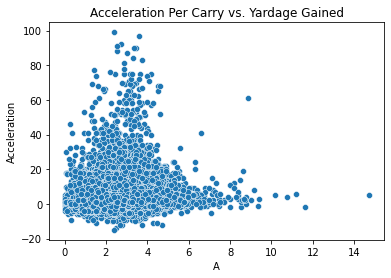

In [82]:
sns.scatterplot(x='A', y='Yards', data=training)
plt.ylabel('Yards')
plt.ylabel('Acceleration')
plt.title("Acceleration Per Carry vs. Yardage Gained")

In [83]:
#There is a positive correlation between acceleration and yards gained
training[["A", "Yards"]].corr()

,A,Yards
A,1.000000,0.131782
Yards,0.131782,1.000000
